In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import AutoModel, AutoConfig
from torch.utils.data import TensorDataset, DataLoader, random_split
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer
from compute_fft import compute_spectrogram, plot_spectrogram, mask
from models.CNN_BiLSTM_Attention import CNN_BiLSTM_Attention
from BESTRq_classes.models import AttentionLSTM, GRUPredictor, AttentionLSTM_spec, CNN, CNN_multiproj, BiLSTM
from BESTRq_classes.train import pretrain, train_decoder, pretrain_multiproj
from models.PainAttFramework.mainPainatt import PainAttnNet

## Defining classes and training functions

In [10]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [3]:
filepath = 'data/cassette-th-data-all.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
xtrain = xtrain.permute(0, 2, 1)
xvalid = xvalid.permute(0, 2, 1)
input_dim = xtrain[0].shape
input_dim[0], xtrain.shape

(2, torch.Size([175995, 2, 600]))

## First overview on raw signals and spectrograms

### Raw signals

In [21]:
device = th.device('mps')

model = BestRqFramework(input_feature_size= 1200, quantizer_dim= 100, codebook_size= 100, mask_time = 30,
                        random_state= 34, mask_prob= 0.1, num_masks_per_signal= 4, batch_size= 300, device = device,
                        raw_signal = False)


inputs = xtrain[:500, :, :].to(device)
    # `(batch size)` Number of available time steps per batch

input_values = model(inputs.unsqueeze(2), masking = False)

input_values.unique(), input_values.shape

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97, 98, 99], device='mps:0'),
 torch.Size([500, 100]))

Text(0.5, 0.98, 'Visualisation du masque')

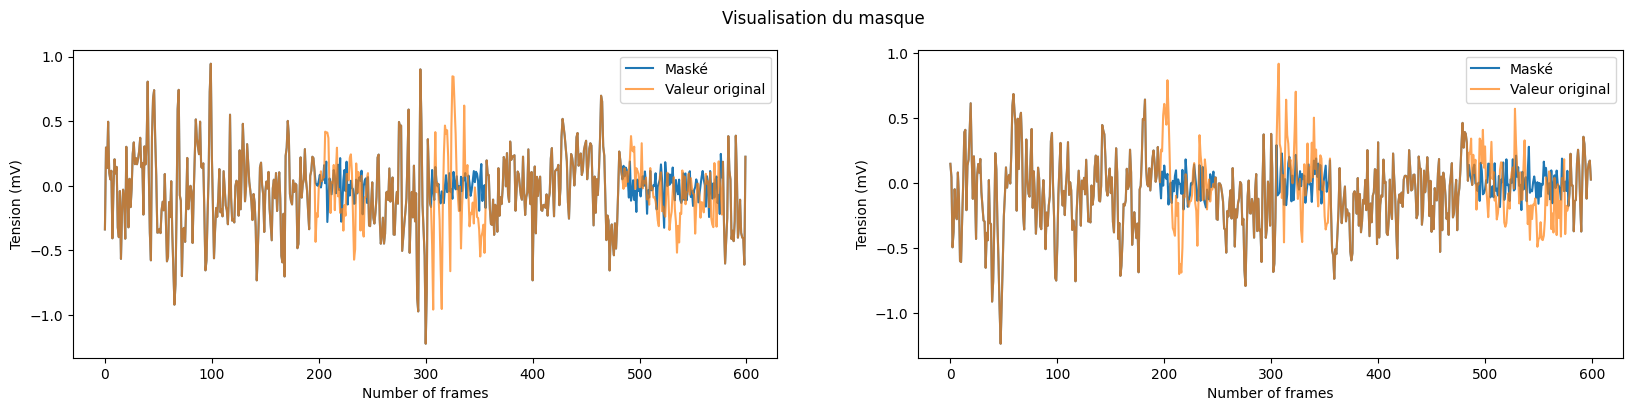

In [6]:
model = BestRqFramework(input_feature_size= 1200, quantizer_dim= 200, codebook_size=  500, mask_time = 30,
                        random_state= 34, mask_prob= 0.1, num_masks_per_signal= 4, batch_size= 200, device = device,
                        raw_signal = False)


inputs = xtrain[:200, : ,:].to(device)


masked_values,_ = mask(inputs, mask_prob = 1, mask_time = 50, number_of_mask = 4, device = device, raw_signal = True)


fig, ax = plt.subplots(1, 2,figsize=(20,4))
for i in range(2):
    ax[i].plot(masked_values[0,i,:].cpu().detach().numpy(), label = 'Maské')
    ax[i].plot(inputs[0, i ,:].cpu().detach().numpy(), label ='Valeur original', alpha = 0.7)
    ax[i].legend()
    ax[i].set_xlabel('Number of frames')
    ax[i].set_ylabel('Tension (mV)')
fig.suptitle('Visualisation du masque')

### Spectrograms

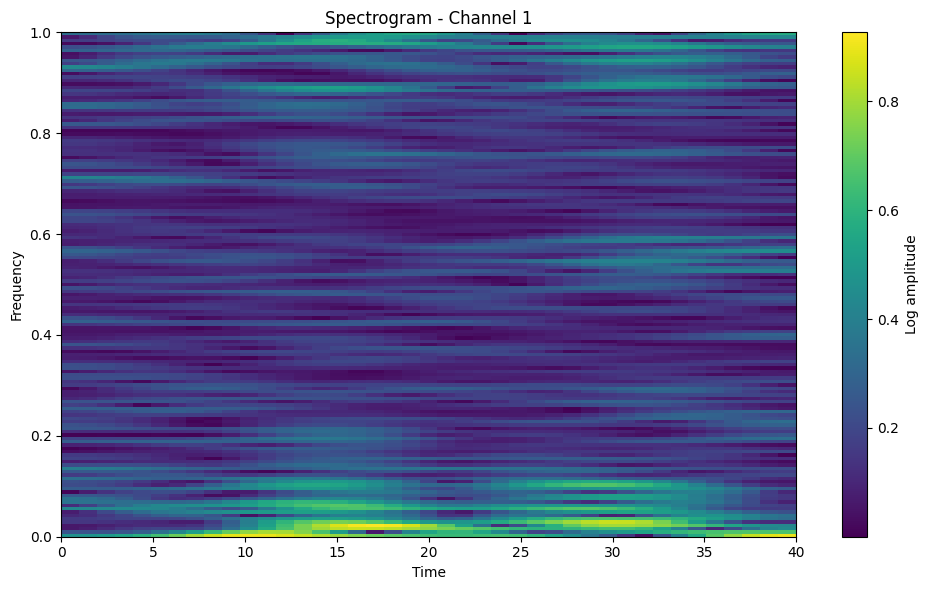

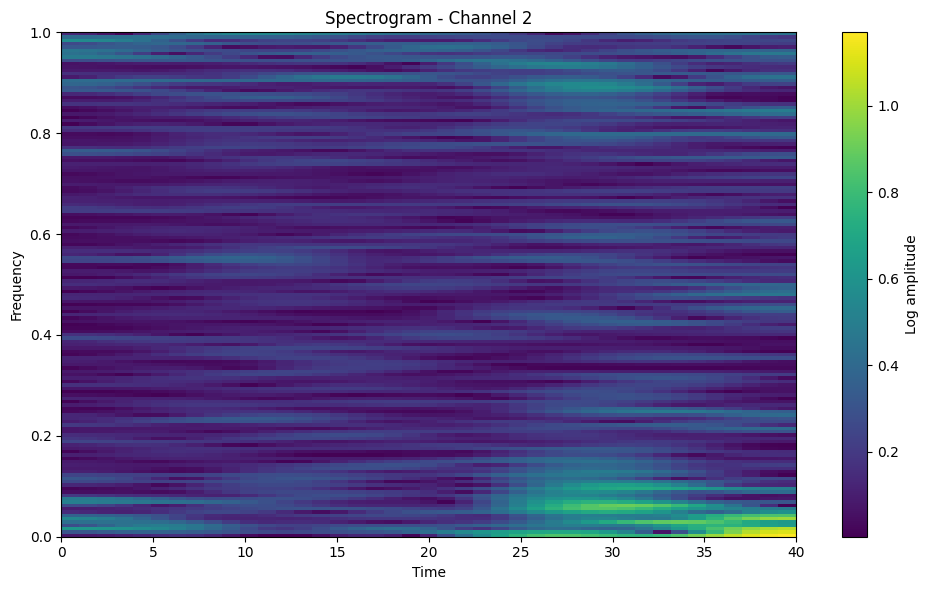

In [10]:
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
inputs = xtrain[:200].to('cpu').view(200, 2, 600)
stft = compute_spectrogram(inputs, n_fft = 300).permute(0,3,1,2)
plot_spectrogram(stft[1, :, :, :])

In [13]:

model = BestRqFramework(input_feature_size= 2*151*41, quantizer_dim= 200, codebook_size=  500, mask_time = 30,
                        random_state= 72829, mask_prob= 0.1, num_masks_per_signal= 4, batch_size= 200, device = device,
                        raw_signal = False)


inputs = stft.to(device) # `(batch size)` Number of available time steps per batch

input_values = model(inputs, masking = False)

input_values.unique()

tensor([ 24,  48,  74,  79, 107, 120, 141, 159, 165, 180, 187], device='mps:0')

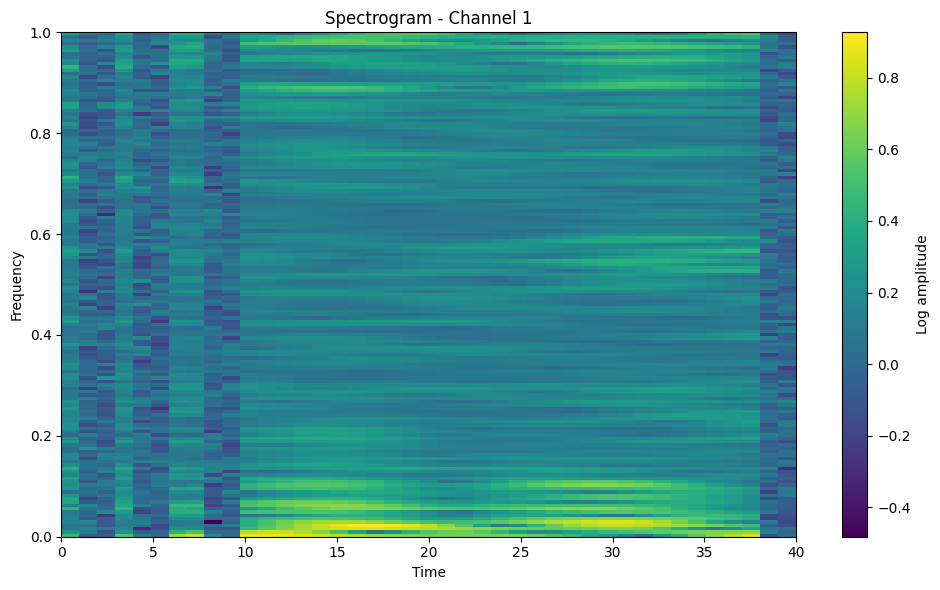

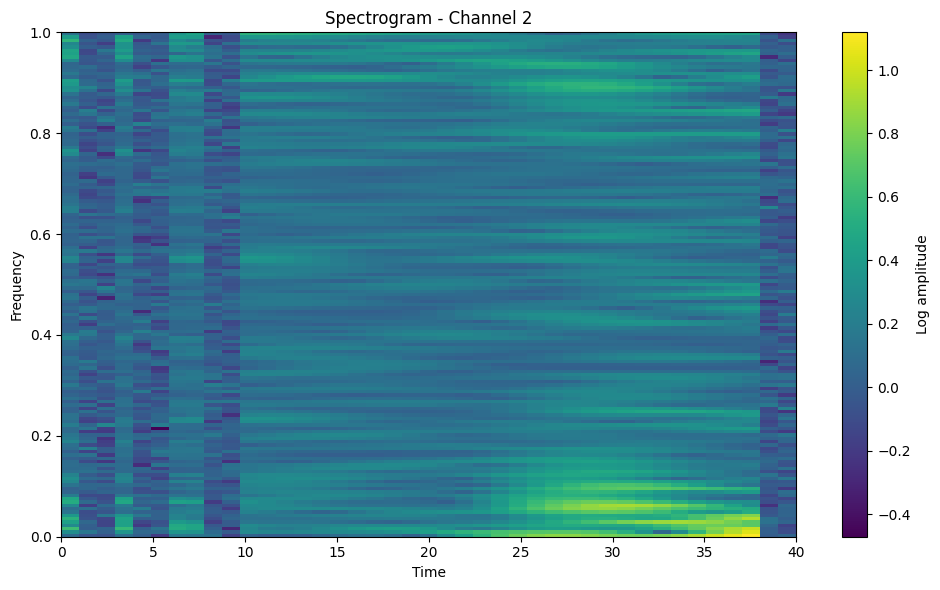

In [9]:
masked_values,_ = mask(stft, mask_prob = 1, mask_time = 2, number_of_mask = 4, device = device, raw_signal = False)
plot_spectrogram(masked_values[1, :, :, :].cpu())

## Training the encoder on raw signals 

In [10]:
xtrain = xtrain.permute(0,2,1)
xvalid = xvalid.permute(0,2,1)

In [31]:
### Try on EOG ####
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
xtrain = xtrain.unsqueeze(1)
xvalid = xvalid.unsqueeze(1)

device = th.device('mps')
encoder = PainAttnNet(N =  3, model_dim = 75, d_mlp = 140, num_heads = 15, dropout = 0.7, num_classes = 100, senet_reduced_size = 30).to(device)


BestRq =  BestRqFramework(input_feature_size= 600, quantizer_dim= 200, codebook_size=  100, mask_time = 30,
                        random_state= 34, mask_prob= 0.2, num_masks_per_signal= 3, batch_size= 200, device = device,
                        raw_signal = False)

train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain([xtrain, ytrain], [xvalid, yvalid], encoder , BestRq, ratio_dataset = 2, epochs=20, lr=1e-3, device = device, raw_signal = True, batch_size = 400)

Projection done
Training loader ok
Validation loader ok
Training started


  0%|          | 0/20 [00:00<?, ?it/s]

Validation


  5%|▌         | 1/20 [25:22<8:02:03, 1522.30s/it]

Epoch 1/20, Train Loss: 3.2654783346436242, Validation Loss: 3.3797652339935302, Training Accuracy: 0.13686830232848848, Validation Accuracy: 0.1687538493122562
Validation


 10%|█         | 2/20 [46:13<6:48:53, 1362.95s/it]

Epoch 2/20, Train Loss: 2.9990591168403626, Validation Loss: 2.865940237045288, Training Accuracy: 0.19462027114560723, Validation Accuracy: 0.26175323342229523
Validation


 15%|█▌        | 3/20 [1:00:15<5:18:42, 1124.83s/it]

Epoch 3/20, Train Loss: 2.712001556699926, Validation Loss: 2.5171772956848146, Training Accuracy: 0.263974908235508, Validation Accuracy: 0.3223157462533361
Validation


 20%|██        | 4/20 [1:13:56<4:28:02, 1005.13s/it]

Epoch 4/20, Train Loss: 2.506634700298309, Validation Loss: 2.3406418132781983, Training Accuracy: 0.30914690273532053, Validation Accuracy: 0.3603982755081092
Validation


 25%|██▌       | 5/20 [1:26:06<3:46:28, 905.91s/it] 

Epoch 5/20, Train Loss: 2.3527599237181924, Validation Loss: 2.271963186264038, Training Accuracy: 0.34490948555064377, Validation Accuracy: 0.36481215356189695
Validation


 30%|███       | 6/20 [1:38:16<3:17:26, 846.16s/it]

Epoch 6/20, Train Loss: 2.2310131192207336, Validation Loss: 2.087450041770935, Training Accuracy: 0.37118310851506303, Validation Accuracy: 0.40751385752412234
Validation


 35%|███▌      | 7/20 [1:53:51<3:09:37, 875.20s/it]

Epoch 7/20, Train Loss: 2.128810392184691, Validation Loss: 1.9998350095748902, Training Accuracy: 0.3940361603236474, Validation Accuracy: 0.4272223362759187
Validation


 40%|████      | 8/20 [2:06:01<2:45:45, 828.76s/it]

Epoch 8/20, Train Loss: 2.046428435499018, Validation Loss: 1.9504628562927246, Training Accuracy: 0.4141618464265827, Validation Accuracy: 0.4387189488811332
Validation


 45%|████▌     | 9/20 [2:18:35<2:27:39, 805.45s/it]

Epoch 9/20, Train Loss: 1.9898898590694774, Validation Loss: 1.9266629219055176, Training Accuracy: 0.4246053842744639, Validation Accuracy: 0.440874563744611
Validation


 50%|█████     | 10/20 [2:30:43<2:10:15, 781.52s/it]

Epoch 10/20, Train Loss: 1.9334356026215986, Validation Loss: 1.8921638774871825, Training Accuracy: 0.4400263645351546, Validation Accuracy: 0.45083145144734144
Validation


 55%|█████▌    | 11/20 [2:43:41<1:57:05, 780.57s/it]

Epoch 11/20, Train Loss: 1.8817346361550418, Validation Loss: 1.8503079319000244, Training Accuracy: 0.45134493221359817, Validation Accuracy: 0.4587353726134264
Validation


 60%|██████    | 12/20 [3:19:48<2:40:17, 1202.19s/it]

Epoch 12/20, Train Loss: 1.8403815903446892, Validation Loss: 1.8519526815414429, Training Accuracy: 0.46024296282827826, Validation Accuracy: 0.45935126257442005
Validation


 65%|██████▌   | 13/20 [3:54:41<2:51:45, 1472.21s/it]

Epoch 13/20, Train Loss: 1.8012930664149198, Validation Loss: 1.8261344671249389, Training Accuracy: 0.4709137811516302, Validation Accuracy: 0.4719770067747896
Validation


 70%|███████   | 14/20 [4:20:31<2:29:33, 1495.62s/it]

Epoch 14/20, Train Loss: 1.7723762625997717, Validation Loss: 1.8035625505447388, Training Accuracy: 0.47732309055990546, Validation Accuracy: 0.47249024840895093
Validation


 75%|███████▌  | 15/20 [4:46:06<2:05:36, 1507.34s/it]

Epoch 15/20, Train Loss: 1.7374030362476003, Validation Loss: 1.773556752204895, Training Accuracy: 0.4861870291032649, Validation Accuracy: 0.48552658591664954
Validation


 80%|████████  | 16/20 [5:10:45<1:39:55, 1498.81s/it]

Epoch 16/20, Train Loss: 1.7060707937587392, Validation Loss: 1.7713773012161256, Training Accuracy: 0.4936986488175733, Validation Accuracy: 0.4851159926093205
Validation


 85%|████████▌ | 17/20 [6:19:48<1:54:42, 2294.15s/it]

Epoch 17/20, Train Loss: 1.6767199938947503, Validation Loss: 1.764717969894409, Training Accuracy: 0.5002670545586781, Validation Accuracy: 0.4857318825703141
Validation


 90%|█████████ | 18/20 [6:41:42<1:06:38, 1999.42s/it]

Epoch 18/20, Train Loss: 1.6534030627120624, Validation Loss: 1.758165922164917, Training Accuracy: 0.5053013170903553, Validation Accuracy: 0.4858345308971464
Validation


 95%|█████████▌| 19/20 [6:55:47<27:32, 1652.67s/it]  

Epoch 19/20, Train Loss: 1.6255270502784036, Validation Loss: 1.7541073846817017, Training Accuracy: 0.5114719819993864, Validation Accuracy: 0.49004311229726955
Validation


100%|██████████| 20/20 [7:10:59<00:00, 1292.97s/it]

Epoch 20/20, Train Loss: 1.608771055394953, Validation Loss: 1.7588481855392457, Training Accuracy: 0.5156653067718218, Validation Accuracy: 0.48645042085814


Text(0.5, 0.98, 'PainAttNet with 2 layers of transformers and codebook_size = 100')

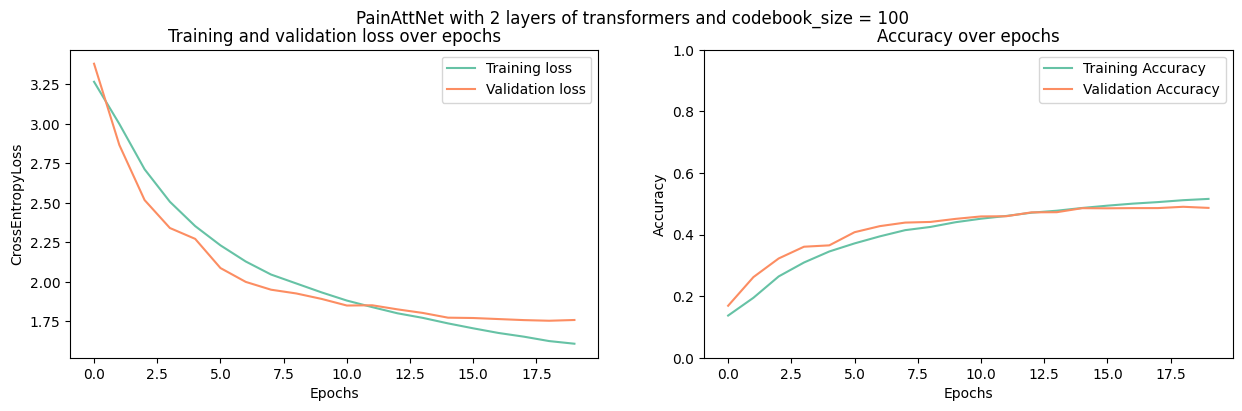

In [32]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('PainAttNet with 2 layers of transformers and codebook_size = 100')

In [4]:
# Testing for EEG
filepath = '/Users/constouille/Documents/GitHub/adl24-sleep-stage/data/cassette-th-data-eeg1.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
xtrain = xtrain.unsqueeze(1)
xvalid = xvalid.unsqueeze(1)

device = th.device('mps')
encoder = PainAttnNet(N =  3, model_dim = 75, d_mlp = 140, num_heads = 5, dropout = 0.5, num_classes = 100, senet_reduced_size = 30).to(device)


BestRq =  BestRqFramework(input_feature_size= 600, quantizer_dim= 200, codebook_size=  100, mask_time = 30,
                        random_state= 34, mask_prob= 0.2, num_masks_per_signal= 3, batch_size= 200, device = device,
                        raw_signal = False)

train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain([xtrain, ytrain], [xvalid, yvalid], encoder , BestRq, ratio_dataset = 2, epochs=20, lr=1e-3, device = device, raw_signal = True, batch_size = 400)

Projection done
Training loader ok
Validation loader ok
Training started


  0%|          | 0/20 [00:00<?, ?it/s]

Validation


  5%|▌         | 1/20 [01:56<36:46, 116.11s/it]

Epoch 1/20, Train Loss: 3.453765053098852, Validation Loss: 3.3956801891326904, Training Accuracy: 0.13306135436435332, Validation Accuracy: 0.18466433997125847
Validation


 10%|█         | 2/20 [03:46<33:50, 112.80s/it]

Epoch 2/20, Train Loss: 3.2227287238294426, Validation Loss: 3.14211217880249, Training Accuracy: 0.1910633317044899, Validation Accuracy: 0.24594539109012523
Validation


 15%|█▌        | 3/20 [05:44<32:37, 115.14s/it]

Epoch 3/20, Train Loss: 3.0537371397018434, Validation Loss: 2.9007076835632324, Training Accuracy: 0.23200790936054638, Validation Accuracy: 0.27632929583247795
Validation


 20%|██        | 4/20 [07:39<30:39, 114.95s/it]

Epoch 4/20, Train Loss: 2.9192338650876826, Validation Loss: 2.770178461074829, Training Accuracy: 0.26183847176608294, Validation Accuracy: 0.30106754259905566
Validation


 25%|██▌       | 5/20 [09:37<29:03, 116.26s/it]

Epoch 5/20, Train Loss: 2.804979472810572, Validation Loss: 2.654238166809082, Training Accuracy: 0.28664613566371583, Validation Accuracy: 0.32323958119482654
Validation


 30%|███       | 6/20 [11:31<26:57, 115.53s/it]

Epoch 6/20, Train Loss: 2.707617099718614, Validation Loss: 2.6058332347869873, Training Accuracy: 0.30826050888098455, Validation Accuracy: 0.3393553685074933
Validation


 35%|███▌      | 7/20 [13:25<24:54, 114.94s/it]

Epoch 7/20, Train Loss: 2.626850391517986, Validation Loss: 2.544406213760376, Training Accuracy: 0.32649976703751266, Validation Accuracy: 0.35095462943954014
Validation


 40%|████      | 8/20 [15:16<22:44, 113.72s/it]

Epoch 8/20, Train Loss: 2.554572034965862, Validation Loss: 2.4750265884399414, Training Accuracy: 0.3417616509653738, Validation Accuracy: 0.3630671320057483
Validation


 45%|████▌     | 9/20 [17:11<20:55, 114.13s/it]

Epoch 9/20, Train Loss: 2.4808060906150122, Validation Loss: 2.443890247344971, Training Accuracy: 0.35721672329738513, Validation Accuracy: 0.36932867994251695
Validation


 50%|█████     | 10/20 [19:15<19:32, 117.23s/it]

Epoch 10/20, Train Loss: 2.4199361140077764, Validation Loss: 2.4102160358428955, Training Accuracy: 0.3685352909758287, Validation Accuracy: 0.3769246561281051
Validation


 55%|█████▌    | 11/20 [21:29<18:20, 122.26s/it]

Epoch 11/20, Train Loss: 2.3744512579657813, Validation Loss: 2.3721151161193847, Training Accuracy: 0.37929702148936895, Validation Accuracy: 0.38267296243071236
Validation


 60%|██████    | 12/20 [23:53<17:10, 128.80s/it]

Epoch 12/20, Train Loss: 2.3288181034001436, Validation Loss: 2.3492311000823975, Training Accuracy: 0.385933611373115, Validation Accuracy: 0.384417983986861
Validation


 65%|██████▌   | 13/20 [26:10<15:20, 131.45s/it]

Epoch 13/20, Train Loss: 2.2868007226423783, Validation Loss: 2.335063629150391, Training Accuracy: 0.3966839778628817, Validation Accuracy: 0.3859577088893451
Validation


 70%|███████   | 14/20 [28:25<13:15, 132.51s/it]

Epoch 14/20, Train Loss: 2.2468555997718465, Validation Loss: 2.3262431716918943, Training Accuracy: 0.40293419093832744, Validation Accuracy: 0.38718948881133236
Validation


 75%|███████▌  | 15/20 [30:38<11:02, 132.45s/it]

Epoch 15/20, Train Loss: 2.21034694314003, Validation Loss: 2.308710689544678, Training Accuracy: 0.4116276691250838, Validation Accuracy: 0.3966331348799015
Validation


 80%|████████  | 16/20 [32:57<08:58, 134.64s/it]

Epoch 16/20, Train Loss: 2.1760017812252044, Validation Loss: 2.2977915668487547, Training Accuracy: 0.4206279759537257, Validation Accuracy: 0.39735167316772735
Validation


 85%|████████▌ | 17/20 [35:14<06:45, 135.29s/it]

Epoch 17/20, Train Loss: 2.1458549028093166, Validation Loss: 2.2929031085968017, Training Accuracy: 0.42173028625975884, Validation Accuracy: 0.3996099363580374
Validation


 90%|█████████ | 18/20 [37:28<04:29, 134.92s/it]

Epoch 18/20, Train Loss: 2.1139756630767477, Validation Loss: 2.2865042591094973, Training Accuracy: 0.42866234076161686, Validation Accuracy: 0.40289468281667007
Validation


 95%|█████████▌| 19/20 [39:47<02:16, 136.13s/it]

Epoch 19/20, Train Loss: 2.0861556562510404, Validation Loss: 2.2877229118347167, Training Accuracy: 0.4357080355012103, Validation Accuracy: 0.3987887497433792
Validation


100%|██████████| 20/20 [42:08<00:00, 126.44s/it]

Epoch 20/20, Train Loss: 2.063738671757958, Validation Loss: 2.299491081237793, Training Accuracy: 0.4386058615634624, Validation Accuracy: 0.39550400328474644


Text(0.5, 0.98, 'PainAttNet for EOG')

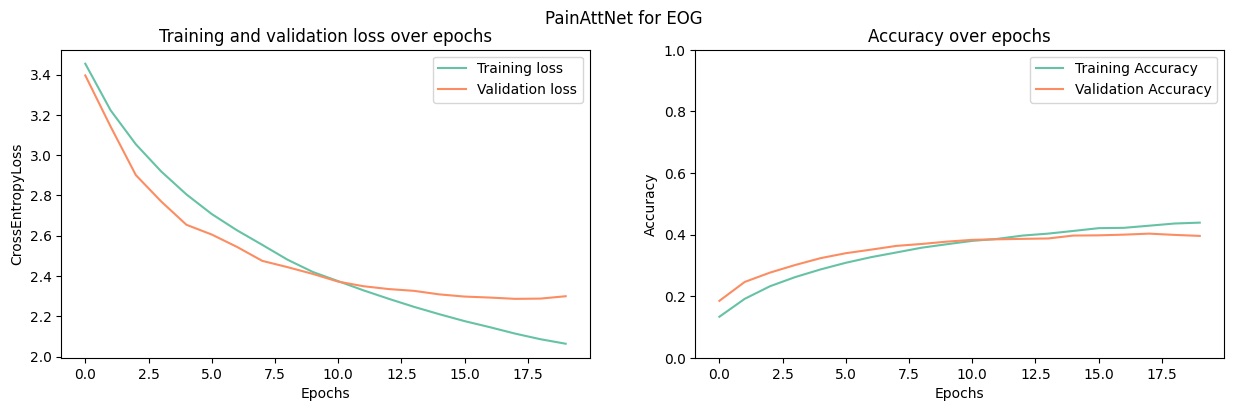

In [5]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('PainAttNet for EEG')

In [7]:
## Saving the model
with open('models/PainAttEEG.pkl', 'wb') as f:
    pickle.dump(encoder, f)

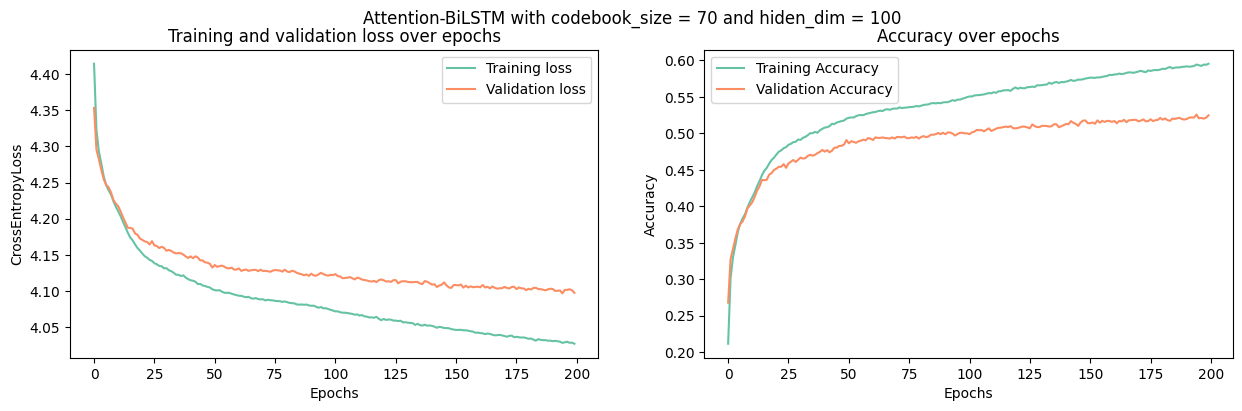

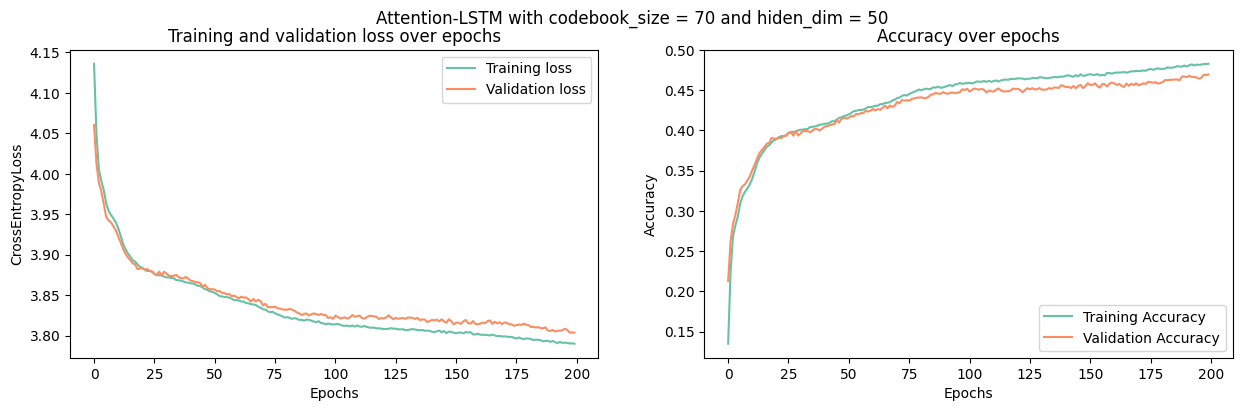

There is some overfitting where the training data is learned in a more efficient way than validation data. (Masking probability here was very high so the LSTM had trouble learning the noise)


## Training the encoder on the spectrogram

In [3]:
## Try on spectrograms


filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
xtrain = xtrain.view(-1, 1, 600)
xvalid = xvalid.view(-1, 1, 600)
stft_train = compute_spectrogram(xtrain, n_fft = 300).permute(0,3,1,2)
stft_valid = compute_spectrogram(xvalid, n_fft = 300).permute(0,3,1,2)

print('spectrogram ok')

spectrogram ok


In [8]:

encoder = CNN(num_classes = 100).to(device)
encoder(stft_train[:2].to(device))

tensor([[ 4.8742e-03,  4.9685e-02,  2.1184e-02, -4.5844e-02, -1.5392e-02,
          3.5482e-02,  1.5969e-02,  3.6087e-02, -3.2628e-02, -3.5172e-02,
         -5.1834e-02, -4.4761e-02,  2.2383e-02, -1.7632e-04, -1.6939e-02,
         -2.0926e-02,  3.5974e-02, -1.6649e-02, -4.7804e-02,  5.3661e-02,
          2.1720e-02,  1.3671e-02, -2.9545e-02, -3.0356e-02, -2.9039e-02,
          3.4068e-02,  1.8140e-02, -4.2335e-02,  3.9030e-02,  1.6276e-02,
          5.2503e-02,  2.7639e-02, -2.1370e-02, -6.4020e-04, -2.0506e-02,
         -6.1709e-03,  6.2655e-03,  9.3875e-03, -4.8119e-02, -5.1174e-02,
          1.2816e-03,  1.7493e-03,  1.9948e-02,  6.8279e-03,  1.7404e-02,
          2.1038e-02,  2.3247e-02,  2.5133e-02,  3.5832e-02, -1.5300e-02,
          1.8962e-03,  9.0598e-03,  3.1927e-02, -2.1355e-02, -1.2407e-02,
         -9.9030e-03,  8.7843e-03,  7.2717e-04,  2.4391e-02, -4.7058e-03,
         -1.0825e-02, -2.1717e-02, -2.7051e-02, -1.8801e-02, -3.1439e-02,
         -3.2438e-02, -1.5607e-02,  1.

In [9]:

BestRq =  BestRqFramework(input_feature_size= 151*41, quantizer_dim= 200, codebook_size=  100, mask_time = 30,
                        random_state= 34, mask_prob= 0.1, num_masks_per_signal= 3, batch_size= 200, device = 'cpu',
                        raw_signal = False)

train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain([stft_train, ytrain], [stft_valid, yvalid], encoder , BestRq, ratio_dataset = 2, epochs=10,
                                                                          lr=1e-3, device = device, raw_signal = False, batch_size = 200, device_for_proj = False)

Projection done
Training loader ok
Validation loader ok
Training started


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


 10%|█         | 1/10 [03:12<28:55, 192.80s/it]

Epoch 1/10, Train Loss: 1.0410217572342266, Validation Loss: 0.7729393328939166, Training Accuracy: 0.6882280077729923, Validation Accuracy: 0.7340381851775816
Validation


 20%|██        | 2/10 [06:14<24:49, 186.20s/it]

Epoch 2/10, Train Loss: 0.8250020600178025, Validation Loss: 0.7087435588544729, Training Accuracy: 0.7317863108969624, Validation Accuracy: 0.7563128721001847
Validation


 30%|███       | 3/10 [09:15<21:25, 183.70s/it]

Epoch 3/10, Train Loss: 0.7628899853337895, Validation Loss: 0.6615062818235281, Training Accuracy: 0.7499801129583963, Validation Accuracy: 0.7750975159104907
Validation


 40%|████      | 4/10 [12:18<18:21, 183.56s/it]

Epoch 4/10, Train Loss: 0.7163206735117869, Validation Loss: 0.619150701834231, Training Accuracy: 0.7635146652726797, Validation Accuracy: 0.7866967768425375
Validation


 50%|█████     | 5/10 [15:18<15:11, 182.26s/it]

Epoch 5/10, Train Loss: 0.6808931159702214, Validation Loss: 0.5904917394628331, Training Accuracy: 0.7746400445469732, Validation Accuracy: 0.7934715664134675
Validation


 60%|██████    | 6/10 [18:21<12:10, 182.66s/it]

Epoch 6/10, Train Loss: 0.651586016877131, Validation Loss: 0.5816817204562985, Training Accuracy: 0.7824698569269407, Validation Accuracy: 0.8011701909258879
Validation


 70%|███████   | 7/10 [21:21<09:04, 181.66s/it]

Epoch 7/10, Train Loss: 0.626192237639969, Validation Loss: 0.5659301542505926, Training Accuracy: 0.79114060706615, Validation Accuracy: 0.8025046191747075
Validation


 80%|████████  | 8/10 [24:20<06:01, 180.83s/it]

Epoch 8/10, Train Loss: 0.6017606122927233, Validation Loss: 0.5517695041335359, Training Accuracy: 0.7981408457106492, Validation Accuracy: 0.8059946622870047
Validation


 90%|█████████ | 9/10 [27:27<03:02, 182.84s/it]

Epoch 9/10, Train Loss: 0.5775891769338738, Validation Loss: 0.5291953220659372, Training Accuracy: 0.8052888166642045, Validation Accuracy: 0.8148224183945801
Validation


100%|██████████| 10/10 [30:35<00:00, 183.55s/it]

Epoch 10/10, Train Loss: 0.551087634536353, Validation Loss: 0.536567919716543, Training Accuracy: 0.8135050058524722, Validation Accuracy: 0.8158489016629029


In [11]:
with open('models/CNNencoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

Text(0.5, 0.98, 'CNN model')

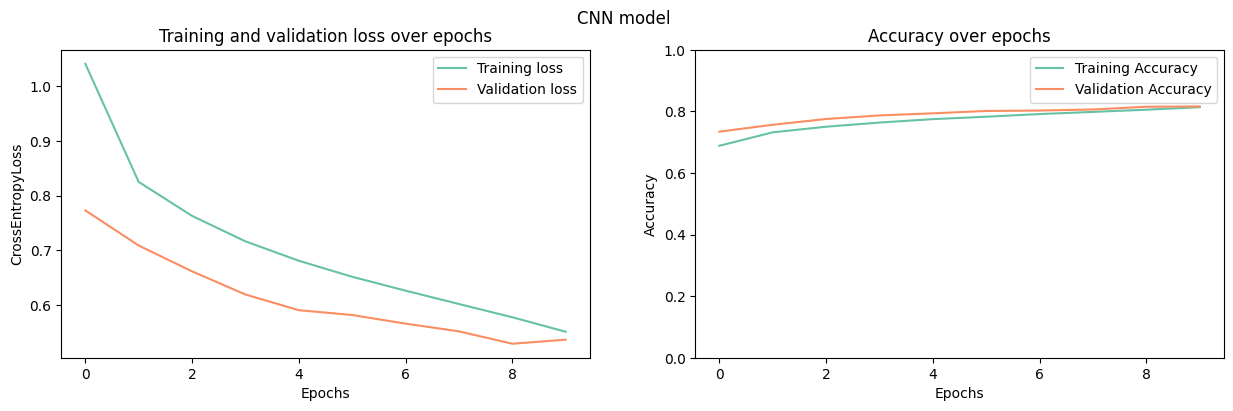

In [14]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('CNN model')


![CNN overfitting.png](<attachment:CNN overfitting.png>)

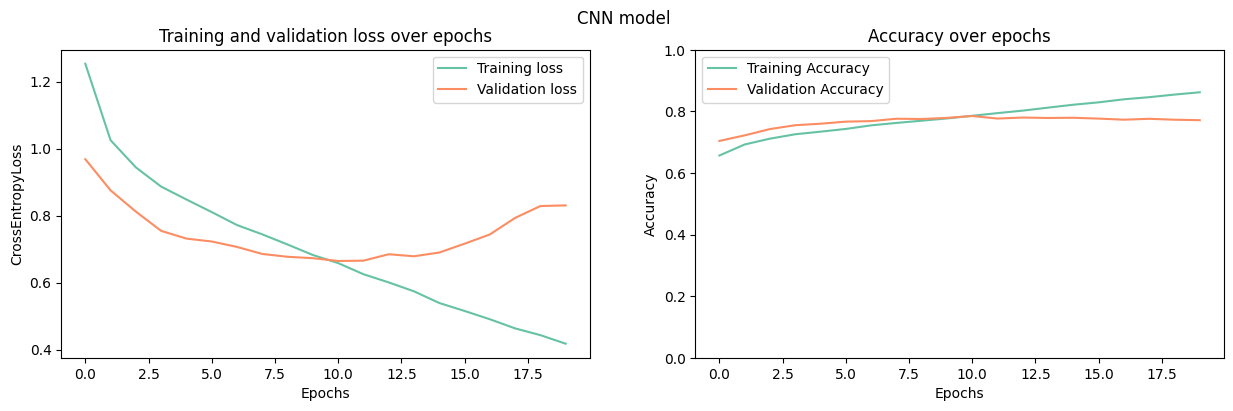

Overfitting for this one 


## Training the decoder

In [2]:
### EOG
with open('models/PainAttEncoder.pkl', 'rb') as f:
    encoder_eog = pickle.load(f)

In [4]:

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(Decoder, self).__init__()

        # Linear layer
        self.linear = nn.Linear(latent_dim, hidden_dim)

        # Activation function
        self.activation = nn.ReLU()

        # Conv1D upsampling layers
        self.conv1d_upsample1 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1)
        self.conv1d_upsample2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        self.lstm = nn.LSTM(input_size = 1, hidden_size = 50, batch_first = True, dropout = dropout_rate, num_layers = 3, bidirectional= True)

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass through linear layer and activation
        x = self.activation(self.linear(x))

        # Upsample using Conv1D
        x = th.unsqueeze(x, 2)  # Add a dimension for Conv1D
        x = self.conv1d_upsample1(x)
        x = self.activation(x)
        x = self.conv1d_upsample2(x)
        x = self.activation(x)

        # Dropout
        x = self.dropout(x)

        x = th.squeeze(x, 2)

        # x, _ = self.lstm(x)

        # x = x.flatten(start_dim = 1)

        # print(x.shape)



        # Output layer
        x = self.output_layer(x)

        return x


decoder_new = Decoder(latent_dim = 100, hidden_dim = 2000, output_dim = 6, dropout_rate = 0.5).to(device)


In [14]:
th.mps.empty_cache()

In [11]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)

decoder = nn.Sequential(nn.Linear(100, 500),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(500, 5)).to(device)
train_decoder([xtrain, ytrain], [xvalid, yvalid], decoder = decoder, encoder = encoder_eog, device = device, epochs = 15, lr = 1e-3)

Training loader ok
Validation loader ok
Training started


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  7%|▋         | 1/15 [05:52<1:22:12, 352.33s/it]

Epoch 1/15, Train Loss: 1.1286284744062207, Validation Loss: 1.0423499437478871, Training Accuracy: 0.580829000823887, Validation Accuracy: 0.6009546294395401
Validation


 13%|█▎        | 2/15 [12:08<1:19:25, 366.55s/it]

Epoch 2/15, Train Loss: 1.0531354592266409, Validation Loss: 1.0246391953566136, Training Accuracy: 0.5972953777095941, Validation Accuracy: 0.6039314309176761
Validation


 20%|██        | 3/15 [18:24<1:14:07, 370.63s/it]

Epoch 3/15, Train Loss: 1.0418014961548827, Validation Loss: 1.020721910855709, Training Accuracy: 0.6009602545526862, Validation Accuracy: 0.6079347156641347
Validation


 27%|██▋       | 4/15 [24:41<1:08:26, 373.34s/it]

Epoch 4/15, Train Loss: 1.035574349490079, Validation Loss: 1.016168392621554, Training Accuracy: 0.6035853291286685, Validation Accuracy: 0.6099876822007801
Validation


 33%|███▎      | 5/15 [30:51<1:01:58, 371.89s/it]

Epoch 5/15, Train Loss: 1.031376202506098, Validation Loss: 1.0125963183549733, Training Accuracy: 0.6044205801301173, Validation Accuracy: 0.6111168137959351
Validation


 40%|████      | 6/15 [37:02<55:45, 371.76s/it]  

Epoch 6/15, Train Loss: 1.0277702744034203, Validation Loss: 1.011950699182657, Training Accuracy: 0.6053751527032017, Validation Accuracy: 0.6082426606446315
Validation


 47%|████▋     | 7/15 [43:15<49:36, 372.06s/it]

Epoch 7/15, Train Loss: 1.0249431426213547, Validation Loss: 1.0101562218788342, Training Accuracy: 0.6063808630927014, Validation Accuracy: 0.6105522479983576
Validation


 53%|█████▎    | 8/15 [49:27<43:25, 372.16s/it]

Epoch 8/15, Train Loss: 1.0219778592952273, Validation Loss: 1.008518865475288, Training Accuracy: 0.6073865734822012, Validation Accuracy: 0.6113734346130159
Validation


 60%|██████    | 9/15 [55:40<37:15, 372.51s/it]

Epoch 9/15, Train Loss: 1.0206511105326088, Validation Loss: 1.0079841522070079, Training Accuracy: 0.6071024745021165, Validation Accuracy: 0.6101416546910285
Validation


 67%|██████▋   | 10/15 [1:02:20<31:44, 380.89s/it]

Epoch 10/15, Train Loss: 1.0180489144880662, Validation Loss: 1.0103632502066784, Training Accuracy: 0.6084036478309043, Validation Accuracy: 0.6104495996715253
Validation


 73%|███████▎  | 11/15 [1:08:49<25:33, 383.49s/it]

Epoch 11/15, Train Loss: 1.016983382573182, Validation Loss: 1.0078852849128919, Training Accuracy: 0.6095457257308446, Validation Accuracy: 0.6104495996715253
Validation


 80%|████████  | 12/15 [1:15:06<19:04, 381.38s/it]

Epoch 12/15, Train Loss: 1.0162920103493063, Validation Loss: 1.005702590331053, Training Accuracy: 0.6084150117901077, Validation Accuracy: 0.609936358037364
Validation


 87%|████████▋ | 13/15 [1:21:15<12:35, 377.75s/it]

Epoch 13/15, Train Loss: 1.0145499658855526, Validation Loss: 1.00395163664451, Training Accuracy: 0.6091138952811159, Validation Accuracy: 0.6146068569082324
Validation


 93%|█████████▎| 14/15 [1:27:28<06:16, 376.06s/it]

Epoch 14/15, Train Loss: 1.012545552274043, Validation Loss: 1.0072723978605025, Training Accuracy: 0.6104718884059206, Validation Accuracy: 0.6185074933278587
Validation


100%|██████████| 15/15 [1:33:35<00:00, 374.35s/it]

Epoch 15/15, Train Loss: 1.012116225944324, Validation Loss: 1.0058193527735197, Training Accuracy: 0.6103014290178699, Validation Accuracy: 0.6159926093204681


([1.1286284744062207,
  1.0531354592266409,
  1.0418014961548827,
  1.035574349490079,
  1.031376202506098,
  1.0277702744034203,
  1.0249431426213547,
  1.0219778592952273,
  1.0206511105326088,
  1.0180489144880662,
  1.016983382573182,
  1.0162920103493063,
  1.0145499658855526,
  1.012545552274043,
  1.012116225944324],
 [1.0423499437478871,
  1.0246391953566136,
  1.020721910855709,
  1.016168392621554,
  1.0125963183549733,
  1.011950699182657,
  1.0101562218788342,
  1.008518865475288,
  1.0079841522070079,
  1.0103632502066784,
  1.0078852849128919,
  1.005702590331053,
  1.00395163664451,
  1.0072723978605025,
  1.0058193527735197],
 [0.580829000823887,
  0.5972953777095941,
  0.6009602545526862,
  0.6035853291286685,
  0.6044205801301173,
  0.6053751527032017,
  0.6063808630927014,
  0.6073865734822012,
  0.6071024745021165,
  0.6084036478309043,
  0.6095457257308446,
  0.6084150117901077,
  0.6091138952811159,
  0.6104718884059206,
  0.6103014290178699],
 [0.6009546294395401

In [36]:
final_model = nn.Sequential(encoder_eog, decoder)

pred = final_model(xtrain[:5].unsqueeze(1).to(device))

th.argmax(pred, dim = 1)

tensor([2, 3, 2, 2, 2], device='mps:0')

In [20]:
with open('models/PainAttFinal_EOG.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [40]:
### Build a confusion matrix
def compute_confusion_matrix(model, dataloader, raw_signal = True):
    model.eval()  # Set the model to evaluation mode
    num_classes = 5
    conf_matrix = th.zeros(num_classes, num_classes)

    with th.no_grad():
        for inputs, labels in tqdm(dataloader):
            # Move inputs and labels to the appropriate device (e.g., GPU)
            if raw_signal:
                inputs = inputs.unsqueeze(1).to(device)
            else:

                inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = th.argmax(outputs, 1)

            # Compute confusion matrix for this batch
            for t, p in zip(labels.view(-1), preds.view(-1)):
                conf_matrix[t.long(), p.long()] += 1

    return conf_matrix


def plot_confusion_matrix(conf_matrix, class_names, model_name):
    plt.figure(figsize=(8, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix for {model_name}')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], '.2f'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

100%|██████████| 39/39 [00:36<00:00,  1.08it/s]


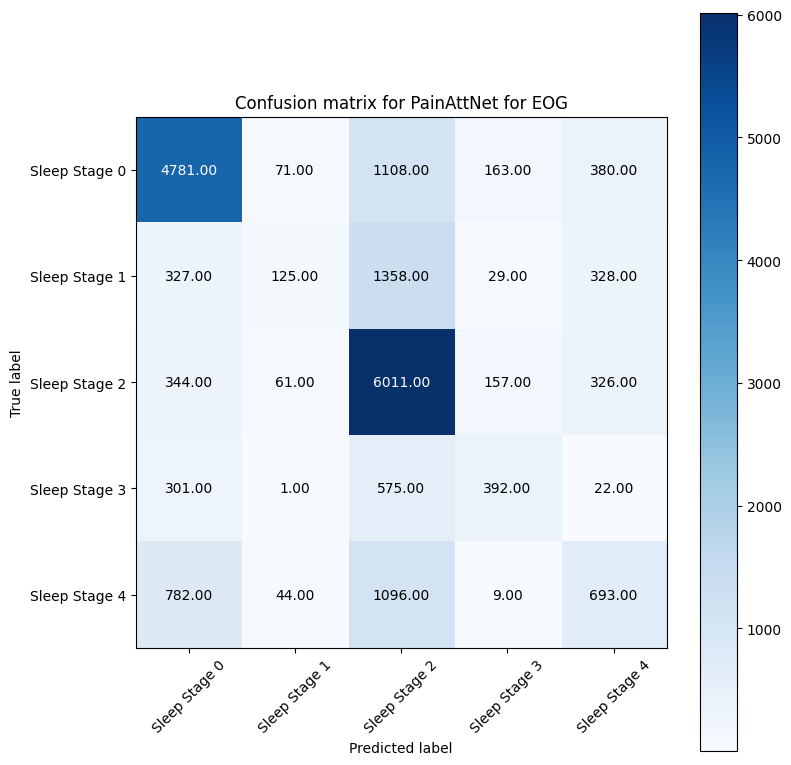

In [44]:
with open('models/PainAttFinal_EOG.pkl', 'rb') as f:
    final_model = pickle.load(f)

dataset_v = TensorDataset(xvalid, yvalid)
valid_loader = DataLoader(dataset_v, batch_size= 500, shuffle=True)

conf = compute_confusion_matrix(final_model, valid_loader, raw_signal = False)
classes = [f"Sleep Stage {i}" for i in range(5)]
plot_confusion_matrix(conf, classes, 'PainAttNet for EOG')


In [46]:
th.bincount(yvalid), th.bincount(ytrain)

(tensor([6503, 2167, 6899, 1291, 2624]),
 tensor([59448, 19355, 62233, 11748, 23211]))

The repartition of classes in the training set and in the validation set seems a little bit off. Sleep stage 0 and 2 are way more present than the other classes. It could explain why our model isn't able to predoct the other classes.

In [48]:
filepath = 'data/cassette-th-data-eeg1.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
with open('models/PainAttEEG.pkl', 'rb') as f:
    encoder_eeg = pickle.load(f)
decoder = nn.Sequential(nn.Linear(100, 500),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(500, 100),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(1000, 5)).to(device)
train_decoder([xtrain, ytrain], [xvalid, yvalid], decoder = decoder, encoder = encoder_eeg, device = device, epochs = 30, lr = 1e-2)

Training loader ok
Validation loader ok
Training started


  0%|          | 0/30 [00:00<?, ?it/s]

Validation


  3%|▎         | 1/30 [03:38<1:45:38, 218.58s/it]

Epoch 1/30, Train Loss: 1.3868237825279885, Validation Loss: 1.2777456962145293, Training Accuracy: 0.3855393619136907, Validation Accuracy: 0.4166495586121946
Validation


  7%|▋         | 2/30 [07:10<1:40:15, 214.82s/it]

Epoch 2/30, Train Loss: 1.3149574598805471, Validation Loss: 1.268863008572505, Training Accuracy: 0.41094917469246284, Validation Accuracy: 0.4414904537056046
Validation


 10%|█         | 3/30 [10:31<1:33:44, 208.30s/it]

Epoch 3/30, Train Loss: 1.3085752949118614, Validation Loss: 1.2586320027326927, Training Accuracy: 0.41967101338106194, Validation Accuracy: 0.44877848491069594
Validation


 13%|█▎        | 4/30 [13:51<1:28:48, 204.92s/it]

Epoch 4/30, Train Loss: 1.3085326295007358, Validation Loss: 1.2763925240590022, Training Accuracy: 0.4219324412625359, Validation Accuracy: 0.43959145965920754
Validation


 17%|█▋        | 5/30 [17:10<1:24:33, 202.94s/it]

Epoch 5/30, Train Loss: 1.3083537732335655, Validation Loss: 1.2693752845128377, Training Accuracy: 0.42203471689536637, Validation Accuracy: 0.4438513652227469
Validation


 20%|██        | 6/30 [20:28<1:20:32, 201.37s/it]

Epoch 6/30, Train Loss: 1.3077557852322406, Validation Loss: 1.266378613618704, Training Accuracy: 0.4221426745077985, Validation Accuracy: 0.4385649763908848
Validation


 23%|██▎       | 7/30 [23:48<1:17:01, 200.92s/it]

Epoch 7/30, Train Loss: 1.3105934177610008, Validation Loss: 1.2724993167779384, Training Accuracy: 0.42203471689536637, Validation Accuracy: 0.4483678916033669
Validation


 27%|██▋       | 8/30 [27:08<1:13:30, 200.49s/it]

Epoch 8/30, Train Loss: 1.3101423778994516, Validation Loss: 1.260493923456241, Training Accuracy: 0.4223301798346544, Validation Accuracy: 0.45616916444261957
Validation


 30%|███       | 9/30 [30:27<1:09:59, 199.98s/it]

Epoch 9/30, Train Loss: 1.3107529516247185, Validation Loss: 1.2741344005633624, Training Accuracy: 0.42321088667291684, Validation Accuracy: 0.429223978649148
Validation


 33%|███▎      | 10/30 [33:48<1:06:45, 200.27s/it]

Epoch 10/30, Train Loss: 1.3125150234184482, Validation Loss: 1.2623565380389874, Training Accuracy: 0.41931304866615526, Validation Accuracy: 0.45098542393758984
Validation


 37%|███▋      | 11/30 [37:10<1:03:35, 200.81s/it]

Epoch 11/30, Train Loss: 1.3066919662735679, Validation Loss: 1.2610377164987416, Training Accuracy: 0.4215687945680275, Validation Accuracy: 0.44164442619585303
Validation


 40%|████      | 12/30 [40:31<1:00:15, 200.86s/it]

Epoch 12/30, Train Loss: 1.3061386184258894, Validation Loss: 1.262088852050977, Training Accuracy: 0.42349498565300153, Validation Accuracy: 0.4533463354547321
Validation


 43%|████▎     | 13/30 [43:57<57:24, 202.61s/it]  

Epoch 13/30, Train Loss: 1.3057011332024226, Validation Loss: 1.2616935112537482, Training Accuracy: 0.4247734310633825, Validation Accuracy: 0.4448778484910696


 43%|████▎     | 13/30 [45:08<59:02, 208.36s/it]


KeyboardInterrupt: 

In [8]:
with open('models/CNNencoder.pkl', 'rb') as f:
    encoder_cnn = pickle.load(f)

In [3]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
xtrain = xtrain.view(-1, 1, 600)
xvalid = xvalid.view(-1, 1, 600)
stft_train = compute_spectrogram(xtrain, n_fft = 300).permute(0,3,1,2)
stft_valid = compute_spectrogram(xvalid, n_fft = 300).permute(0,3,1,2)


In [14]:
print('spectrogram ok')

decoder = nn.Sequential(nn.Linear(100, 500),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(500, 5)).to(device)
train_decoder([stft_train, ytrain], [stft_valid, yvalid], decoder = decoder, encoder = encoder_cnn, device = device, epochs = 11, lr = 1e-3, device_for_proj = False)

spectrogram ok
Training loader ok
Validation loader ok
Training started


  0%|          | 0/11 [00:00<?, ?it/s]

Validation


  9%|▉         | 1/11 [17:44<2:57:25, 1064.59s/it]

Epoch 1/11, Train Loss: 1.2192342023957858, Validation Loss: 0.9900221350865487, Training Accuracy: 0.587738288019546, Validation Accuracy: 0.6188154383083556
Validation


 18%|█▊        | 2/11 [27:15<1:56:08, 774.27s/it] 

Epoch 2/11, Train Loss: 1.0151276847516948, Validation Loss: 0.9663842075910324, Training Accuracy: 0.6165970624165459, Validation Accuracy: 0.6254875795524533
Validation


 27%|██▋       | 3/11 [36:19<1:29:14, 669.27s/it]

Epoch 3/11, Train Loss: 1.005965400317853, Validation Loss: 0.9633428974029346, Training Accuracy: 0.6203073950964516, Validation Accuracy: 0.6299527817696572
Validation


 36%|███▋      | 4/11 [45:26<1:12:25, 620.81s/it]

Epoch 4/11, Train Loss: 1.0029869418252597, Validation Loss: 0.9632489665960654, Training Accuracy: 0.6204721725049007, Validation Accuracy: 0.6252822828987887
Validation


 45%|████▌     | 5/11 [54:21<58:58, 589.76s/it]  

Epoch 5/11, Train Loss: 1.0030272469263186, Validation Loss: 0.9591231178014706, Training Accuracy: 0.6188755362368249, Validation Accuracy: 0.6273352494354342
Validation


 55%|█████▍    | 6/11 [1:03:39<48:14, 578.97s/it]

Epoch 6/11, Train Loss: 1.0085494912822137, Validation Loss: 0.9611414747360425, Training Accuracy: 0.6188243984204097, Validation Accuracy: 0.6278484910695956
Validation


 64%|██████▎   | 7/11 [1:12:41<37:48, 567.09s/it]

Epoch 7/11, Train Loss: 1.0058149946006862, Validation Loss: 0.9474499684113723, Training Accuracy: 0.6180346032557743, Validation Accuracy: 0.6280537877232601
Validation


 73%|███████▎  | 8/11 [1:22:01<28:13, 564.59s/it]

Epoch 8/11, Train Loss: 1.0017103673043577, Validation Loss: 0.9508353104958167, Training Accuracy: 0.6195857836870365, Validation Accuracy: 0.6309279408745637
Validation


 82%|████████▏ | 9/11 [1:32:54<19:44, 592.42s/it]

Epoch 9/11, Train Loss: 1.0048540044914593, Validation Loss: 0.9542526144247788, Training Accuracy: 0.6194607801357993, Validation Accuracy: 0.6266680353110244
Validation


 91%|█████████ | 10/11 [1:42:35<09:48, 588.83s/it]

Epoch 10/11, Train Loss: 1.0057629988613455, Validation Loss: 0.9503494944327917, Training Accuracy: 0.617949373561749, Validation Accuracy: 0.6305173475672347
Validation


100%|██████████| 11/11 [1:52:16<00:00, 612.42s/it]

Epoch 11/11, Train Loss: 0.9991741710427132, Validation Loss: 0.9423504991409106, Training Accuracy: 0.6211937839143158, Validation Accuracy: 0.6308252925477315


([1.2192342023957858,
  1.0151276847516948,
  1.005965400317853,
  1.0029869418252597,
  1.0030272469263186,
  1.0085494912822137,
  1.0058149946006862,
  1.0017103673043577,
  1.0048540044914593,
  1.0057629988613455,
  0.9991741710427132],
 [0.9900221350865487,
  0.9663842075910324,
  0.9633428974029346,
  0.9632489665960654,
  0.9591231178014706,
  0.9611414747360425,
  0.9474499684113723,
  0.9508353104958167,
  0.9542526144247788,
  0.9503494944327917,
  0.9423504991409106],
 [0.587738288019546,
  0.6165970624165459,
  0.6203073950964516,
  0.6204721725049007,
  0.6188755362368249,
  0.6188243984204097,
  0.6180346032557743,
  0.6195857836870365,
  0.6194607801357993,
  0.617949373561749,
  0.6211937839143158],
 [0.6188154383083556,
  0.6254875795524533,
  0.6299527817696572,
  0.6252822828987887,
  0.6273352494354342,
  0.6278484910695956,
  0.6280537877232601,
  0.6309279408745637,
  0.6266680353110244,
  0.6305173475672347,
  0.6308252925477315])

In [20]:
final_model = nn.Sequential(encoder_cnn, decoder)
with open('models/CNN_final.pkl', 'wb') as f:
    pickle.dump(final_model, f)

100%|██████████| 98/98 [00:26<00:00,  3.63it/s]


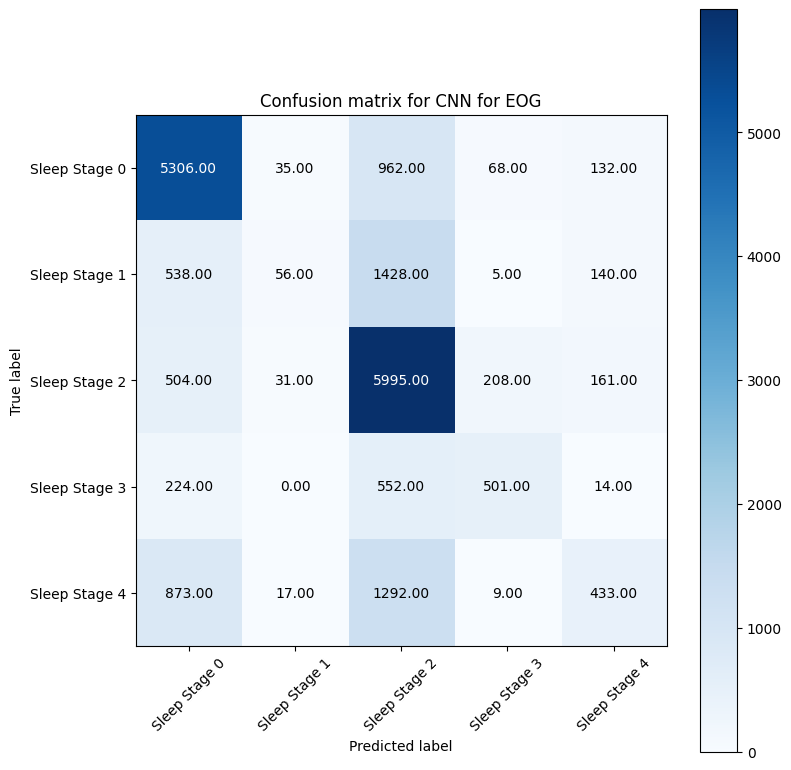

In [46]:
with open('models/CNN_final.pkl', 'rb') as f:
    final_model = pickle.load(f)
datavalid = TensorDataset(stft_valid, yvalid)
datavalid = DataLoader(datavalid, batch_size= 200, shuffle=True)
conf = compute_confusion_matrix(final_model, datavalid, raw_signal = False)
classes = [f"Sleep Stage {i}" for i in range(5)]
plot_confusion_matrix(conf, classes,  'CNN for EOG')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('Encoder + Decoder')

## Vrai BESTRQFramework

In [2]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
xtrain = xtrain.view(-1, 1, 600)
xvalid = xvalid.view(-1, 1, 600)
stft_train = compute_spectrogram(xtrain, n_fft = 300).permute(0,3,1,2)
stft_valid = compute_spectrogram(xvalid, n_fft = 300).permute(0,3,1,2)

In [17]:
encoder = CNN_multiproj(quantizer_dim= 100, codebook_size= 100).to(device)
encoder(stft_train[:2].to(device))

tensor([[[-0.0731, -0.0095,  0.1559,  ..., -0.0943, -0.0508, -0.1817],
         [-0.1252,  0.0344,  0.1616,  ..., -0.2245, -0.1708, -0.1040],
         [ 0.0542, -0.0068,  0.1729,  ..., -0.0358, -0.0555, -0.1353],
         ...,
         [ 0.1084,  0.0201,  0.0458,  ..., -0.1267,  0.0758, -0.1998],
         [-0.0459, -0.1331,  0.0802,  ..., -0.1765, -0.0010, -0.1567],
         [ 0.0146, -0.1289,  0.0098,  ..., -0.0162, -0.0144, -0.3391]],

        [[-0.0798, -0.0164,  0.1266,  ..., -0.1499, -0.0635, -0.1872],
         [-0.0074, -0.0518,  0.0785,  ..., -0.0432,  0.0800, -0.4244],
         [ 0.0519, -0.0288,  0.0275,  ..., -0.0581,  0.0393, -0.2275],
         ...,
         [-0.0854, -0.1105,  0.1654,  ...,  0.0926,  0.0578, -0.1748],
         [ 0.0260, -0.0409,  0.0734,  ..., -0.1622,  0.0707, -0.2477],
         [-0.0534, -0.0154,  0.0409,  ..., -0.0316,  0.1168, -0.2211]]],
       device='mps:0', grad_fn=<ViewBackward0>)

In [18]:
BestRq =  BestRqFramework(input_feature_size= 151*41, quantizer_dim= 100, codebook_size=  100, mask_time = 30,
                        random_state= 34, mask_prob= 0.1, num_masks_per_signal= 3, batch_size= 200, device = 'cpu',
                        raw_signal = False)

train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain_multiproj([stft_train, ytrain], [stft_valid, yvalid], encoder , BestRq, ratio_dataset = 2, epochs=20,
                                                                          lr=1e-3, device = device, raw_signal = False, batch_size = 200, device_for_proj = False)

Projection done
Training loader ok
Validation loader ok


python(16349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training started


  0%|          | 0/20 [00:00<?, ?it/s]

Validation


  5%|▌         | 1/20 [02:06<40:09, 126.80s/it]

Epoch 1/20, Train Loss: 1.5968510711734945, Validation Loss: 1.0843140568052019, Training WER: 0.44363364660158894, Validation WER: 0.34666084992814616
Validation


 10%|█         | 2/20 [04:17<38:42, 129.01s/it]

Epoch 2/20, Train Loss: 1.1618457777933642, Validation Loss: 0.9139917906449766, Training WER: 0.36117344909485566, Validation WER: 0.30498254978443845
Validation


 15%|█▌        | 3/20 [06:25<36:24, 128.51s/it]

Epoch 3/20, Train Loss: 1.0440816838632931, Validation Loss: 0.8381837411802642, Training WER: 0.3323561030489675, Validation WER: 0.28454116197905976
Validation


 20%|██        | 4/20 [08:34<34:19, 128.69s/it]

Epoch 4/20, Train Loss: 0.9793806520375339, Validation Loss: 0.7814587938542269, Training WER: 0.3160702069388727, Validation WER: 0.26924861424758784
Validation


 25%|██▌       | 5/20 [10:37<31:41, 126.79s/it]

Epoch 5/20, Train Loss: 0.9342220535332506, Validation Loss: 0.742297717503139, Training WER: 0.30468709160539553, Validation WER: 0.2575456785054403
Validation


 30%|███       | 6/20 [12:40<29:17, 125.52s/it]

Epoch 6/20, Train Loss: 0.9031439824537797, Validation Loss: 0.7133364385488082, Training WER: 0.29697898792004274, Validation WER: 0.24996612605214535
Validation


 35%|███▌      | 7/20 [14:48<27:20, 126.19s/it]

Epoch 7/20, Train Loss: 0.877795426141132, Validation Loss: 0.6963816333790215, Training WER: 0.2904697887427978, Validation WER: 0.24491480188872916
Validation


 40%|████      | 8/20 [16:52<25:07, 125.61s/it]

Epoch 8/20, Train Loss: 0.8615200778300112, Validation Loss: 0.6758107774111689, Training WER: 0.28614873234314836, Validation WER: 0.23834428248819542
Validation


 45%|████▌     | 9/20 [18:55<22:52, 124.79s/it]

Epoch 9/20, Train Loss: 0.843119556795467, Validation Loss: 0.6646466133545856, Training WER: 0.28126424764480606, Validation WER: 0.23584992814617123
Validation


 50%|█████     | 10/20 [21:05<21:04, 126.43s/it]

Epoch 10/20, Train Loss: 0.8293622297319498, Validation Loss: 0.6520565042690355, Training WER: 0.2778077661738469, Validation WER: 0.23104393348388425
Validation


 55%|█████▌    | 11/20 [23:09<18:50, 125.65s/it]

Epoch 11/20, Train Loss: 0.8191780374808745, Validation Loss: 0.6438168688696257, Training WER: 0.27471902451219926, Validation WER: 0.22879593512625748
Validation


 60%|██████    | 12/20 [25:16<16:49, 126.16s/it]

Epoch 12/20, Train Loss: 0.8076686981049451, Validation Loss: 0.6382732585984834, Training WER: 0.27195256656476896, Validation WER: 0.22771094231164024
Validation


 65%|██████▌   | 13/20 [27:23<14:43, 126.24s/it]

Epoch 13/20, Train Loss: 0.7997812714089046, Validation Loss: 0.6274638711189737, Training WER: 0.2699360205461549, Validation WER: 0.22390371586943136
Validation


 70%|███████   | 14/20 [29:33<12:43, 127.29s/it]

Epoch 14/20, Train Loss: 0.7936086948622357, Validation Loss: 0.6280396118456003, Training WER: 0.268251985863154, Validation WER: 0.22597721207144336
Validation


 75%|███████▌  | 15/20 [31:37<10:31, 126.29s/it]

Epoch 15/20, Train Loss: 0.7873347247188741, Validation Loss: 0.6192950788809328, Training WER: 0.2664274918463132, Validation WER: 0.22272018066105526
Validation


 80%|████████  | 16/20 [33:40<08:22, 125.54s/it]

Epoch 16/20, Train Loss: 0.7799434358423406, Validation Loss: 0.6128937966969549, Training WER: 0.2645733377274226, Validation WER: 0.21973824676657772
Validation


 85%|████████▌ | 17/20 [35:43<06:13, 124.56s/it]

Epoch 17/20, Train Loss: 0.7739848326552998, Validation Loss: 0.6118155766506584, Training WER: 0.26293885018807445, Validation WER: 0.2206641346746048
Validation


 90%|█████████ | 18/20 [37:46<04:08, 124.34s/it]

Epoch 18/20, Train Loss: 0.7718755957755176, Validation Loss: 0.6087188161149317, Training WER: 0.26236735343250345, Validation WER: 0.21925990556353928
Validation


 95%|█████████▌| 19/20 [40:02<02:07, 127.71s/it]

Epoch 19/20, Train Loss: 0.7678813301704147, Validation Loss: 0.6036963827755987, Training WER: 0.261189131447663, Validation WER: 0.21758673783617322
Validation


100%|██████████| 20/20 [42:09<00:00, 126.47s/it]

Epoch 20/20, Train Loss: 0.7623485324057666, Validation Loss: 0.6024758268375786, Training WER: 0.25970533086355224, Validation WER: 0.2179778279614042


Text(0.5, 0.98, 'CNN with real BEST-RQ Frameork')

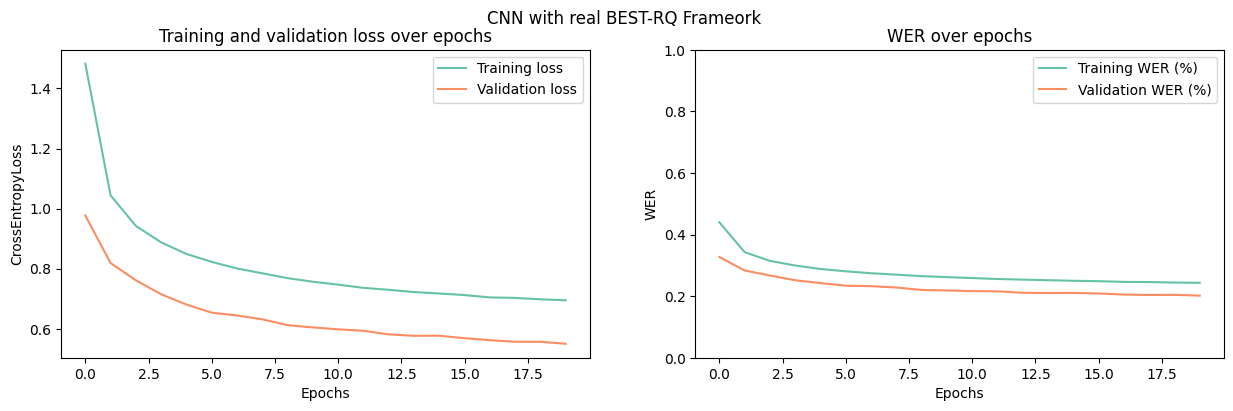

In [9]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training WER (%)')
ax[1].plot(valid_accuracies, label ='Validation WER (%)')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('WER over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('WER')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('CNN with real BEST-RQ Frameork')

In [19]:
with open('models/CNNencode_bestrq.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [ ]:
test = encoder(stft_train[:500].to(device))
test

tensor([[[-43.4364, -29.0319, -26.3731,  ..., -28.8159, -17.1423, -28.8890],
         [-29.6250, -24.4671, -19.0335,  ..., -19.3245, -10.6386, -24.5434],
         [-25.5169, -22.1276, -23.4333,  ..., -26.9367, -16.3571, -35.4581],
         ...,
         [-21.1598, -18.8474, -20.2134,  ..., -22.1658, -16.9517, -15.9701],
         [-18.6587, -32.9012,  -4.0951,  ..., -34.3376, -16.3126, -14.5108],
         [-40.7457, -32.1455, -31.1688,  ..., -29.7623, -12.6317, -19.8264]],

        [[-52.4220, -32.3297, -29.7957,  ..., -31.8565, -19.5659, -35.7726],
         [-26.6864, -24.1224, -17.8668,  ..., -19.6458,  -9.3296, -21.9004],
         [-31.0751, -27.4216, -28.8680,  ..., -33.5748, -20.2813, -41.9429],
         ...,
         [-15.5078, -13.7248, -13.4206,  ..., -17.5662, -12.9959,  -9.0545],
         [-10.0854, -17.7529,  -0.5198,  ..., -19.3968,  -9.1628,  -9.2420],
         [-31.8260, -29.1938, -24.6912,  ..., -26.3050,  -9.1819, -18.1488]],

        [[-53.9404, -35.0730, -32.4417,  ...

In [45]:
def train_decoder(training_data, valid_data, decoder,encoder, epochs=10, lr=1e-3, device = 'cpu', raw_signal = True, batch_size = 500, device_for_proj = True):

    xtrain, ytrain= training_data
    xvalid, yvalid = valid_data

    if device_for_proj:

        # Convert tensors to device
        xtrain, ytrain = xtrain.to(device), ytrain.to(device)
        xvalid, yvalid = xvalid.to(device), yvalid.to(device)


    dataset_t = TensorDataset(xtrain, ytrain)
    train_loader = DataLoader(dataset_t, batch_size= batch_size, shuffle=True)
    print('Training loader ok')

    dataset_v = TensorDataset(xvalid, yvalid)
    valid_loader = DataLoader(dataset_v, batch_size= batch_size, shuffle=True)
    print('Validation loader ok')




    optimizer = optim.Adam(decoder.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    sofmax = nn.Softmax(dim = 1)

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch


    print('Training started')
    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        decoder.train()
        encoder.eval()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            if device_for_proj:
                inputs = inputs.unsqueeze(1).to(device)
            else:
                inputs, labels = inputs.to(device), labels.to(device)
            encoder_outs = encoder(inputs)
            preds = decoder(encoder_outs)
            loss = loss_function(preds, labels.long())
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.argmax(preds, dim=1)
            total += labels.size(0)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        print('Validation')

        # Validation phase
        decoder.eval()

        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in valid_loader:
                if device_for_proj:
                    inputs = inputs.unsqueeze(1).to(device)
                else:
                    inputs, labels = inputs.to(device), labels.to(device)
                encoder_outs = encoder(inputs)
                preds = decoder(encoder_outs)

                loss = loss_function(preds, labels.long())
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.argmax(preds, dim=1)
                total += labels.size(0)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(valid_loader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [3]:
with open('models/CNNencode_bestrq.pkl', 'rb') as f:
    encoder = pickle.load(f)


In [46]:


device = 'cpu'
encoder.to(device)

decoder = BiLSTM(input_dim=100, hidden_dim= 500, nstack= 2).to(device)
train_decoder([stft_train, ytrain], [stft_valid, yvalid], decoder = decoder, encoder = encoder, device = device, epochs = 11, lr = 1e-3, device_for_proj = False)

Training loader ok
Validation loader ok
Training started


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([500, 100, 100])


  0%|          | 0/11 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [10]:
device = th.device('mps')
a = encoder(stft_train[:100].to(device))
decoder = BiLSTM(input_dim=100, hidden_dim= 500, nstack= 2).to(device)
a

tensor([[[-13.8692, -19.7288, -16.4401,  ...,  -6.8388,  -5.8889, -14.0592],
         [-19.2667, -20.2667, -10.9652,  ...,  -9.3731,  -9.6075,  -4.1016],
         [-14.2339, -20.5919, -19.0405,  ..., -12.3698, -13.8866, -21.0255],
         ...,
         [ -9.9719, -14.8283,  -8.1889,  ..., -11.9960, -15.3262, -12.2743],
         [ -7.4907, -21.9872, -18.1834,  ...,  -0.3934, -13.1923, -19.1362],
         [-14.3915, -23.6043, -29.7011,  ..., -26.9194, -34.6895, -37.3020]],

        [[-25.6997, -33.3943, -31.7048,  ..., -16.8499, -14.2784, -27.2641],
         [-32.5976, -29.5845, -17.3598,  ..., -15.0174, -15.7455,  -8.4127],
         [-11.4558, -14.1669, -12.9789,  ...,  -9.2678, -11.5729, -15.1053],
         ...,
         [-16.3540, -22.1262, -13.2701,  ..., -21.5441, -22.6303, -21.1164],
         [ -9.1147, -26.4802, -22.6762,  ...,  -0.5256, -15.2754, -22.5807],
         [-13.9970, -26.3897, -29.6854,  ..., -27.8548, -37.7513, -34.0108]],

        [[-14.8397, -20.4964, -18.0103,  ...

In [33]:
b = decoder(a.to(device))
b

torch.Size([100, 100, 100])


tensor([[ 2.2321e-02,  1.1385e-01, -1.5338e-02,  2.3230e-02,  1.3656e-01],
        [ 9.8441e-02,  2.6618e-02, -8.9816e-02,  8.6485e-02,  1.0202e-01],
        [-5.2148e-02, -2.9204e-02, -9.2944e-02,  4.5053e-02,  1.6989e-01],
        [-8.2899e-02,  7.6349e-02, -8.3140e-02, -6.5892e-02,  6.4848e-02],
        [-1.2825e-02,  6.2898e-03, -2.3422e-01, -7.5169e-02,  1.1134e-01],
        [-4.3184e-02,  5.5097e-03, -1.8360e-01, -7.8495e-02, -2.8413e-02],
        [ 3.7827e-02, -6.5890e-02, -7.3895e-03, -1.0275e-02,  5.5352e-02],
        [-4.4273e-02, -9.6995e-02, -4.9091e-02,  8.3353e-02,  9.2968e-02],
        [-1.9653e-03,  1.0929e-01, -1.0972e-01, -5.4876e-02,  1.2190e-01],
        [-3.9420e-03, -4.9496e-02, -2.6990e-02,  4.7200e-02, -9.2587e-02],
        [-4.4588e-02,  6.9521e-02, -4.2458e-02, -2.0603e-02,  3.8927e-02],
        [ 2.0647e-02,  7.9732e-03, -2.0645e-02,  9.9772e-02, -5.9686e-02],
        [-4.7283e-02,  1.4243e-01, -4.1198e-02, -2.5639e-03,  1.0160e-01],
        [ 2.3393e-02,  5.

In [39]:
loss = nn.CrossEntropyLoss().to(device)
y = ytrain[:100]
loss(b.to(device), y.to(device)), y.shape

RuntimeError: expected scalar type Long but found Int

In [44]:
y.long()

tensor([2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        2, 0, 2, 0, 2, 2, 0, 1, 0, 0, 4, 0, 0, 2, 0, 0, 4, 0, 2, 1, 1, 0, 0, 0,
        4, 2, 0, 4, 0, 4, 1, 0, 4, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 4, 0, 0, 1, 4,
        2, 0, 0, 4, 0, 0, 2, 0, 0, 2, 0, 0, 4, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2,
        0, 2, 4, 1])